## EFM Demo

[EnergyFlow website](https://www.energyflow.network)

In this tutorial, we demonstrate how to compute the Energy Flow Moments using the EnergyFlow package. We also demonstrate how to speed up collider observbles and verify all of the linear relations among the EFPs discussed in [1911.04491](https://arxiv.org/abs/1911.04491) that arise in the limit of few particles or spacetime dimensions.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

import energyflow as ef

### Plot Style

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

### Energy Flow Moments
The Energy Flow Moments (EFMs) were introduced in [1911.04491](https://arxiv.org/abs/1911.04491) as the moments of the radiation pattern. They are fully-symmetric tensors defined as:
$$ \mathcal I^{\mu_1\mu_2\cdots\mu_v} \equiv 2^{v/2}\sum_{i=1}^M E_i n_i^{\mu_1} n_i^{\mu_2} \cdots n_i^{\mu_v},\,\,\,\,\,\,\,\, n_i^\mu \equiv p_i^\mu / E_i$$
for an event or jet with $M$ particles.
At a hadron collider like the LHC, we use the particle transverse momentum $p_T$ in place of the energy $E$.


EFMs provide a $\mathcal O(M)$ way to compute $\beta=2$ Energy Flow Polynomials (EFPs) or Energy Correlation Functions (ECFs).
For instance, the invariant mass of an event is $\mathcal O(M^2)$ to compute as an ECF, but can easily be computed in $\mathcal O(M)$ via:
$$ m^2 = \sum_{i=1}^M \sum_{j=1}^M p_{i\mu} p_{i}^{\mu} = \left( \sum_{i=1}^M E_i n_i^\mu \right)^2 = \frac12\mathcal I_\mu \mathcal I^\mu$$
The EFMs provide the natural generalization of this idea to all correlator observables.

As a reminder, the EFPs are multiparticle energy correlators with angular monomials specified by multigraphs $G$.
They were introduced in [1712.07124](https://arxiv.org/abs/1712.07124) and form a linear basis for all infrared- and collinear-safe (IRC-safe) observables.
They are defined as:
$$ {\rm EFP}_G = \sum_{i_1=1}^M \sum_{i_2=1}^M \cdots \sum_{i_N=1}^M E_{i_1} E_{i_2} \cdots E_{i_N} \prod_{(k,\ell)\in G} \theta_{i_k i_\ell}, $$
where $G$ is a multigraph as a list of edges and $\theta_{ij}$ is an angular distance between particles. Here we use $\theta_{ij} = (2 n_i^\mu n_{j\mu})^{\beta/2}$.

Below, we compute an EFP in the standard way and using contractions of EFMs. EnergyFlow will do this for you automatically if you use EFPs with the `hadrefm` or `eeefm` measure!

In [3]:
# generate a random event
event = ef.gen_random_events(1, 25, dim=4)

# the metric
metric = np.diag([1,-1,-1,-1])

# compute several energy flow moments
EFM2 = ef.EFM(2, measure='hadrefm', coords='epxpypz')(event)
EFM3 = ef.EFM(3, measure='hadrefm', coords='epxpypz')(event)

# take a look at the EFM Imunu
print(EFM2)

[[ 3.36864801 -0.37543981 -0.07672024 -0.01552002]
 [-0.37543981  0.90235865  0.06150039 -0.12656877]
 [-0.07672024  0.06150039  1.09764135  0.00562418]
 [-0.01552002 -0.12656877  0.00562418  1.36864801]]


In [4]:
# compute the EFP corresponding to the "icecreamcone" graph in the usual way
EFP_correlator = ef.EFP([(0,1),(0,1),(0,2),(1,2)], measure='hadrdot', coords='epxpypz', beta=2)(event)

# compute the EFP corresponding to "icecreamcone" as a contraction of EFMs with the metric
EFP_contraction = np.einsum('abc,def,gh,ad,be,cg,fh->', EFM3, EFM3, EFM2, *([metric]*4))

# compute the EFP corresponding to "icecreamcone" with explicit sums
pTs = np.sqrt(event[:,1]**2 + event[:,2]**2)
zs, ns = pTs/np.sum(pTs), (event/pTs[:,np.newaxis])
thetas = np.asarray([[np.sum(2*ni*nj*np.asarray([1,-1,-1,-1])) for ni in ns] for nj in ns])

EFP_sums = 0
for i in range(len(event)):
    for j in range(len(event)):
        for k in range(len(event)):
            EFP_sums += zs[i] * zs[j] * zs[k] * thetas[i,j] * thetas[i,j] * thetas[i,k] * thetas[j,k]

# ensure that the two values agree
print(EFP_correlator - EFP_contraction)
print(EFP_correlator - EFP_sums)

-1.1368683772161603e-13
-2.8421709430404007e-13


### Fast Computation of Multi-Prong Taggers
The $C_N$ family of $N$-prong taggers was introduced in [1305.0007](https://arxiv.org/abs/1305.0007) built from multiparticle correlators as:
$$C_1 = \sum_{i=1}^M \sum_{j=1}^M z_i z_j \theta_{ij}$$
$$C_2 = \frac{\left(\sum_{i=1}^M \sum_{j=1}^M\sum_{k=1}^M z_i z_j z_k \theta_{ij}\theta_{jk}\theta_{ik}\right)}{\left(\sum_{i=1}^M \sum_{j=1}^M z_i z_j \theta_{ij}\right)^2}$$
$$C_3 = \frac{\left(\sum_{i=1}^M \sum_{j=1}^M\sum_{k=1}^M \sum_{\ell=1}^M z_i z_j z_k z_\ell \theta_{ij}\theta_{ik}\theta_{i\ell}\theta_{jk}\theta_{j\ell}\theta_{k\ell}\right)\left(\sum_{i=1}^M \sum_{j=1}^M z_i z_j \theta_{ij}\right)}{\left(\sum_{i=1}^M \sum_{j=1}^M\sum_{k=1}^M z_i z_j z_k \theta_{ij}\theta_{jk}\theta_{ik}\right)^2}$$
where $z_i = p_{T,i}/\sum_{j=1}^M p_{T,j}$. Here we use $\theta_{ij} = (2p_i^\mu p_{j\mu}/p_{T,i} p_{T,j})^{\beta/2}$, though the speedups also apply when $\theta_{ij}$ is the rapidity-azimuth distance (squared).

Further, the $D_2$ two-prong tagger was introduced in [1409.6298](https://arxiv.org/abs/1409.6298) and defined as:
$$D_2 = \frac{\left(\sum_{i=1}^M \sum_{j=1}^M\sum_{k=1}^M z_i z_j z_k \theta_{ij}\theta_{jk}\theta_{ik}\right)}{\left(\sum_{i=1}^M \sum_{j=1}^M z_i z_j \theta_{ij}\right)^3}$$

With $\beta=2$, we will demonstrate that $C_N$, which is naively $\mathcal O(M^{N+1})$ to compute, can actually be computed in $\mathcal O(M)$. Similarly, $D_2$, which is naively $\mathcal O(M^3)$ to compute, can be computed in $\mathcal O(M)$ as well.

Below, we time the $\mathcal O(M)$ computation of these observables via EFM computation of EFPs using the `hadrdot` measure. You can see the asymptotic linear scaling being achieved, far outpacing the naive computation of these observables.

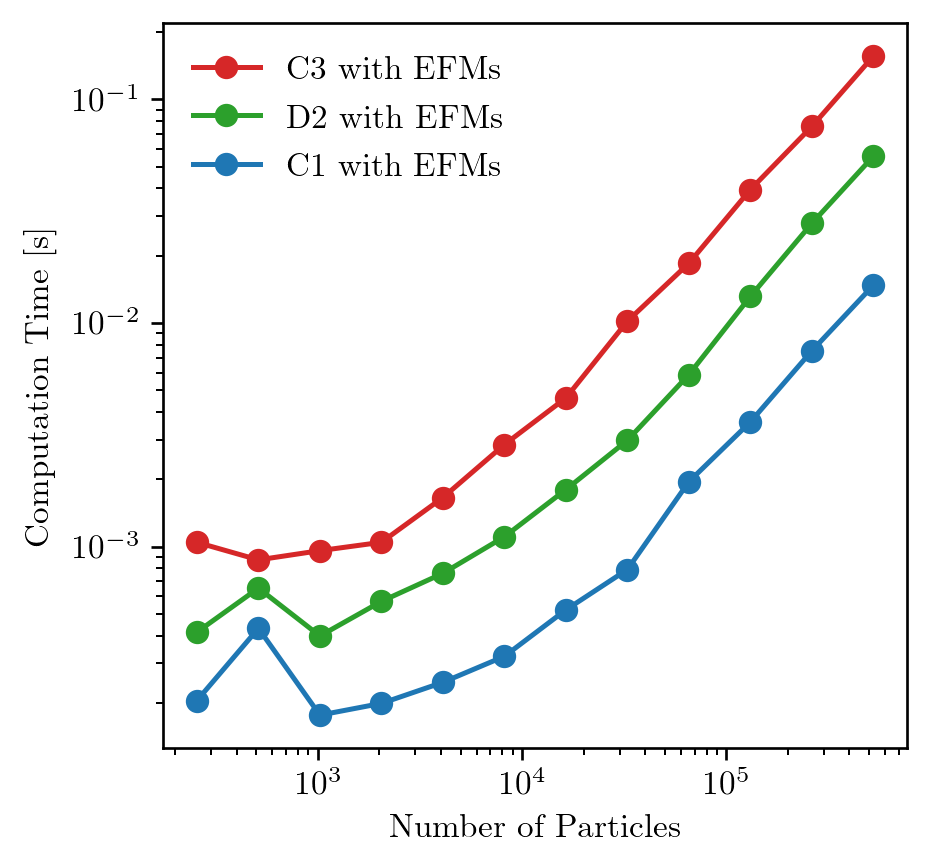

In [5]:
# specify the relevant graphs and EFPs to compute C1, D2, C3
line = ef.EFP([(0,1)], measure='hadrefm', coords='epxpypz', beta=2)
triangle = ef.EFP([(0,1), (0,2), (1,2)], measure='hadrefm', coords='epxpypz', beta=2)
kite = ef.EFP([(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)], measure='hadrefm', coords='epxpypz', beta=2)

# which numbers of particles to evaluate the observables for
Ms = 2**np.arange(8,20)
C1_times, D2_times, C3_times = [], [] ,[]

# compute the observables for each M. This can be repeated for a more robust estimate
for M in Ms:
    # generate a random event with M particles
    event = ef.gen_random_events(1, M, dim=4)

    # time the computation of C1
    start = time.time()
    C1 = line(event)
    C1_times.append(time.time()-start)
    
    # time the computation of D2
    start = time.time()
    D2 = triangle(event)/line(event)**3
    D2_times.append(time.time()-start)
    
    # time the comuputation of C3
    start = time.time()
    C3 = kite(event)*line(event)/triangle(event)**2
    C3_times.append(time.time()-start)
    

# plot the results
plt.plot(Ms, C3_times, '-o', label='C3 with EFMs', color='tab:red')
plt.plot(Ms, D2_times, '-o', label='D2 with EFMs', color='tab:green')
plt.plot(Ms, C1_times, '-o', label='C1 with EFMs', color='tab:blue')

# plot settings
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Number of Particles')
plt.ylabel('Computation Time [s]')
plt.show()

## Linear Relations
When the number of particles or spacetime dimensions is "small", linear relationships among the EFPs emerge. These can best be understood in the language of EFMs and other moment structures.

Here, we numerically illustrate the identities proved in the paper. To begin, we enumerate every relevant multigraph that we will need.

In [6]:
graphs ={# d=0
        'dot': [],

        # d=1
        'line': [(0,1)],

        # d=2
        'dumbbell': [(0,1), (0,1)],
        'wedge': [(0,1),(1,2)],
        'linesqd' : [(0,1),(2,3)],

        # d = 3
        'tribell' : [(0,1),(0,1),(0,1)],
        'triangle' : [(0,1),(1,2),(2,0)],
        'asymwedge' : [(0,1),(0,1),(1,2)],
        'birdfoot' : [(0,1),(0,2),(0,3)],
        'chain' : [(0,1),(1,2),(2,3)],
        'linedumbbell' : [(0,1),(2,3),(2,3)],
        'linewedge' : [(0,1),(2,3),(3,4)],
        'linecbd'  : [(0,1),(2,3),(4,5)],

        # d = 4
        'quadbell' : [(0,1),(0,1),(0,1),(0,1)],
        'doublewedge' : [(0,1),(0,1),(1,2),(1,2)],
        'icecreamcone' : [(0,1),(0,1),(1,2),(2,0)],
        'asymwedge2' : [(0,1),(0,1),(0,1),(1,2)],
        'square' : [(0,1),(1,2),(2,3),(3,0)],
        'flyswatter' : [(0,1),(1,2),(2,3),(3,1)],
        'chain2mid' : [(0,1),(1,2),(1,2),(2,3)],
        'chain2end' : [(0,1),(1,2),(2,3),(2,3)],
        'asymbirdfoot' : [(0,1),(0,1),(1,2),(1,3)],
        'bigbirdfoot' : [(0,1),(0,2),(0,3),(0,4)],
        'dog' : [(0,1),(1,2),(2,3),(2,4)],
        'bigchain' : [(0,1),(1,2),(2,3),(3,4)],

        'dumbbellwedge' : [(0,1),(0,1),(2,3),(3,4)],
        'triangleline' : [(0,1),(1,2),(2,0),(3,4)],
        'dumbbellsqd' : [(0,1),(0,1),(2,3),(2,3)],

        # d = 5
        'pentagon' : [(0,1),(1,2),(2,3),(3,4),(4,0)],
        'triangledumbbell': [(0,1),(0,1),(2,3),(3,4),(4,2)]
        }

### Finite Particle Relations

When the number of particles in the event is small, a number of linear relations among the EFPs emerge due to the simplified nature of the configuration. The typical example of this is that "triangle" or ECF3 vanishes for $M=2$ particles. There is an entire family of these relations, which we check below for $M=2$.

These identities hold for EFPs with any choice of $\beta$ or angular measure $\theta_{ij}$.
Play around with the coefficients to see that these identies are non-trivial!

In [7]:
# pick a random event with 2 particles
event = ef.gen_random_events(1, 2, dim=4)

# compute the value of all of the EFPs on this event
d = {name: ef.EFP(graph, measure='hadr', coords='epxpypz', beta=1)(event) for name,graph in graphs.items()}

# check that the identities in the paper are valid (i.e. = 0)
print(2 * d['wedge'] - d['dumbbell'])
print(2 * d['triangle'])
print(d['tribell'] - 2 * d['asymwedge'])
print(2 * d['chain'] - d['linedumbbell'] - d['triangle'])
print(d['birdfoot'] + d['chain'] - d['asymwedge'])

0.0
0.0
1.7763568394002505e-15
0.0
0.0


### Finite Dimension Relations
As the number of spacetime dimensions is finite (e.g. 4), the inner product structure of $\theta_{ij} = n_i^\mu n_{j\mu}$ for $\beta=2$ EFPs gives rise to additional identities.

These identities hold for EFPs with $\beta=2$ when $\theta_{ij}$ is an inner product. Play around with the coefficients to see that these identies are non-trivial!

In [8]:
# Three Dimensions
# pick a random event in 3 dimensions
event = ef.gen_random_events(1, 25, dim=3)

# get the transverse momenta and pairwise distances for the event
pTs = np.sqrt(event[:,1]**2 + event[:,2]**2)
zs, ns = pTs/np.sum(pTs), (event/pTs[:,np.newaxis])
thetas = np.asarray([[np.sum(2*ni*nj*np.asarray([1]+[-1]*(len(ni)-1))) for ni in ns] for nj in ns])

# compute the value of all of the EFPs on this event
d = {name: ef.EFP(graph)(zs=zs, thetas=thetas) for name,graph in graphs.items()}

# check that the identity in the paper is valid (i.e. = 0)
print(6*d['bigchain']-12*d['chain']+6*d['linedumbbell']+4*d['triangle']-2*d['triangleline']-3*d['dumbbellwedge'])

0.0


In [9]:
# Four Dimensions
# pick a random event in 4 dimensions
event = ef.gen_random_events(1, 25, dim=4)

# get the transverse momenta and pairwise distances for the event
pTs = np.sqrt(event[:,1]**2 + event[:,2]**2)
zs, ns = pTs/np.sum(pTs), (event/pTs[:,np.newaxis])
thetas = np.asarray([[np.sum(2*ni*nj*np.asarray([1]+[-1]*(len(ni)-1))) for ni in ns] for nj in ns])

# compute the value of all of the EFPs on this event
d = {name: ef.EFP(graph)(zs=zs, thetas=thetas) for name,graph in graphs.items()}

# check that the identity in the paper is valid (i.e. = 0)
print(6*d['pentagon']-5*d['triangledumbbell'])

2.7284841053187847e-12


### Center of Momentum Relations

For kinematic polynomials or $\beta=2$ EFPs in $e^+e^-$ collisions, additional relations emerge when working in the center of momentum.

Correlators which correspond to multigraphs with "leaves", i.e valency-1 vertices, are no longer independent. Further, counting the number of leafless multigraphs also counts the number of independent kinematic polynomials.

Here we count the multigraphs with up to 10 edges for connected and all multigraphs. Going further requires specialized graph packages such as Nauty. The sequences up to 16 edges have been added to the Online-Encyclopedia of Integer Sequences as [A307316](https://oeis.org/A307316) and [A307317](https://oeis.org/A307317).

In [10]:
# function to check if a graph is leafless (i.e. has no valency-1 vertices)
def leafless(graph):
    return not 1 in np.unique(graph, return_counts=True)[1]

# count the number of leafless multigraphs (all or just connected) with degree d
ds = np.arange(11)
counts_all, counts_con = [], []

# for each degree, get the graphs with edges<=d and check whether they are leafless
for d in ds:
    counts_all.append(np.sum([leafless(graph) for graph in ef.EFPSet(('d<=',d)).graphs()]))
    counts_con.append(np.sum([leafless(graph) for graph in ef.EFPSet(('d<=',d), ('p==',1)).graphs()]))

# note: computed counts are cumulative, must take the difference to get individual d    
counts_all = np.asarray(counts_all[1:]) - np.asarray(counts_all[:-1])
counts_con = np.asarray(counts_con[1:]) - np.asarray(counts_con[:-1])

In [11]:
# display the results in a table
print("Counting Multigraphs")
print("Edges", "  Num. Connected & Leafless", "  Num. Leafless")
for d, count_con, count_all in zip(ds[1:], counts_con, counts_all):
    print("{:4g}    {:4g}                        {:4g}".format(d, count_con, count_all))

Counting Multigraphs
Edges   Num. Connected & Leafless   Num. Leafless
   1       0                           0
   2       1                           1
   3       2                           2
   4       4                           5
   5       9                          11
   6      26                          34
   7      68                          87
   8     217                         279
   9     718                         897
  10    2553                        3129


### Euclidean Slicing Relations
When using the $\beta=2$ EFPs for $e^+e^-$ collisions, there is an interesting correspondence between the EFMs and generalized sphericity tensors:
$$\Theta^{j_1j_2\cdots j_v} \equiv \sum_{i=1}^M E_i \hat n_i^{j_1}\hat n_i^{j_2}\cdots \hat n_i^{j_v},\,\,\,\,\,\,\, \hat n_i \equiv \vec p/E.$$

In particular, the spatial components of the EFMs are precisely the sphericity tensors. For instance:
$$\mathcal I^{j_1j_2} = 2\Theta^{j_1j_2}.$$

Polynomials obtained by contracting the generalized sphericity tensors are interesting objects, closely related to famous event shapes such as the $C$ and $D$ parameters. The relationship between $\Theta$ and $\mathcal I$ induces a close relationship between these polynomials and the EFPs.

Here, we showcase a translation table between the sphericity polynomials and EFPs for graphs of degree up to 4. Play with the coefficients in the table to see that these relationships are nontrivial!

In [12]:
# function to compute the "euclidean" (i.e. sphericity) polynomial of a graph using EFPs
def euc(efp, event):
    l = list(range(event.shape[1])) + [0]
    return (-1)**efp.d * efp(event[:,l])

# specify the desired graphs, here all graphs up to d<=3 and all connected graphs with d=4
gnames = [# d=0
          'dot',
          # d = 1
          'line',
          # d = 2
          'dumbbell', 'wedge', 'linesqd',
          # d = 3
          'tribell', 'triangle', 'asymwedge', 'birdfoot', 'chain', 'linedumbbell', 'linewedge', 'linecbd',
          # d = 4 (connected)
          'quadbell', 'doublewedge', 'icecreamcone', 'asymwedge2', 'square', 'flyswatter',
          'chain2mid', 'chain2end', 'asymbirdfoot', 'bigbirdfoot', 'dog', 'bigchain']

# take the entire translation matrix from sphericity polynomials to EFPs from the paepr
M = np.asarray([
    [1,   0,  0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2,  -1,  0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4,  -4,  1, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4,  -4,  0, 1,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4,  -4,  0, 0,   1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  6, 0,   0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  0, 6,   0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  2, 4,   0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  0, 6,   0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  0, 4,   2, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  2, 0,   4, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  0, 2,   4, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, -12,  0, 0,   6, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [16,-32, 24, 0,   0,-8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [16,-32,  8, 16,  0, 0, 0,-8, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [16,-32,  4, 20,  0, 0,-4,-4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [16,-32, 12, 12,  0,-2, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [16,-32,  0, 16,  8, 0, 0, 0, 0,-8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [16,-32,  0, 20,  4, 0,-2, 0,-2,-4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [16,-32,  4, 16,  4, 0, 0,-4, 0,-4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [16,-32,  4, 12,  8, 0, 0,-2, 0,-4,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [16,-32,  4, 20,  0, 0, 0,-4,-4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [16,-32,  0, 24,  0, 0, 0, 0,-8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [16,-32,  0, 16,  8, 0, 0, 0,-2,-4, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [16,-32,  0, 12, 12, 0, 0, 0, 0,-4, 0,-4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
])

In [13]:
# generate a random event
event = ef.gen_random_events(1, 25, dim=4)

# compute the EFPs and Sphericity polynomials
efps = [ef.EFP(graphs[name], coords='epxpypz', measure='eeefm', beta=2)(event) for name in gnames]
eucs = [euc(ef.EFP(graphs[name], coords='epxpypz', measure='eeefm', beta=2),event) for name in gnames]

# convert the results to numpy arrays
efps, eucs = np.asarray(efps), np.asarray(eucs)

# check that all of the relationships are valid (i.e. = 0)
print(efps - np.dot(M,eucs))
print(np.max(efps - np.dot(M,eucs)))

[ 0.00000000e+00  4.44089210e-16  1.77635684e-15  8.88178420e-16
  1.77635684e-15  1.06581410e-14  8.88178420e-16  3.55271368e-15
  4.44089210e-15  1.77635684e-15  5.32907052e-15  3.55271368e-15
  4.44089210e-15 -2.13162821e-14  1.42108547e-14  1.59872116e-14
  2.84217094e-14  3.55271368e-15  8.88178420e-15  7.10542736e-15
  1.77635684e-14  2.13162821e-14  8.88178420e-15  1.59872116e-14
  5.32907052e-15]
2.842170943040401e-14


Now let's explore the relationship between the $C$ and $D$ parameters, sphericity polynomials, and the EFPs. We can write the $C$ and $D$ parameters as contractions of the sphericity tensors.

We also use our table above to translate these into linear combinations of EFPs.

In [14]:
# generate a random event
event = ef.gen_random_events(1, 25, dim=4)

# get the theta matrix
theta = ef.EFM(2, measure='eeefm')(event)[1:,1:]/2

# compute the C and D parameters
C = 3/2 * (np.trace(theta)**2 - np.trace(np.dot(theta,theta)))
D = 27 * np.linalg.det(theta)

# compute some sphericity polynomials
euc_dumbbell = euc(ef.EFP(graphs['dumbbell'], coords='epxpypz', measure='eeefm', beta=2),event)
euc_triangle = euc(ef.EFP(graphs['triangle'], coords='epxpypz', measure='eeefm', beta=2),event)

# check the graphical expressions for the C and D parameters (i.e. difference = 0)
print(-3/8 * euc_dumbbell + 3/2 - C)
print(9/8 * euc_triangle - 27/8 * euc_dumbbell + 9/2 - D)

# we can also translate these into linear combinations of EFPs as follows
vec = np.dot(M[:3,:3].T, np.asarray([3/2, 0, -3/8]))
print(vec[vec!=0], np.asarray(gnames[:3])[vec!=0])

vec = np.dot(M[:7,:7].T, np.asarray([9/2, 0, -27/8, 0, 0, 0, 9/8]))
print(vec[vec!=0], np.asarray(gnames[:7])[vec!=0])

0.0
-1.6653345369377348e-15
[ 1.5   -0.375] ['line' 'dumbbell']
[-3.375  6.75  -1.125] ['dumbbell' 'wedge' 'triangle']


Finally, since the generalized sphericity tensors live in 3 spacetime dimensions, they are sensitive to three-dimensional finite dimension identities. These can be obtained using our usual techniques and then translated to relations among EFPs using our table.

In [15]:
# generate a random event
event = ef.gen_random_events(1, 25, dim=4)

# compute some sphericity polynomials
euc_line          = euc(ef.EFP(graphs['line'],          coords='epxpypz', measure='eeefm', beta=2),event)
euc_dumbbell      = euc(ef.EFP(graphs['dumbbell'],      coords='epxpypz', measure='eeefm', beta=2),event)
euc_wedge         = euc(ef.EFP(graphs['wedge'],         coords='epxpypz', measure='eeefm', beta=2),event)
euc_triangle      = euc(ef.EFP(graphs['triangle'],      coords='epxpypz', measure='eeefm', beta=2),event)
euc_linedumbbell  = euc(ef.EFP(graphs['linedumbbell'],  coords='epxpypz', measure='eeefm', beta=2),event)
euc_square        = euc(ef.EFP(graphs['square'],        coords='epxpypz', measure='eeefm', beta=2),event)
euc_dumbbellsqd   = euc(ef.EFP(graphs['dumbbellsqd'],   coords='epxpypz', measure='eeefm', beta=2),event)
euc_dumbbellwedge = euc(ef.EFP(graphs['dumbbellwedge'], coords='epxpypz', measure='eeefm', beta=2),event)
euc_triangleline  = euc(ef.EFP(graphs['triangleline'],  coords='epxpypz', measure='eeefm', beta=2),event)
euc_chain         = euc(ef.EFP(graphs['chain'],         coords='epxpypz', measure='eeefm', beta=2),event)
euc_bigchain      = euc(ef.EFP(graphs['bigchain'],      coords='epxpypz', measure='eeefm', beta=2),event)

# verify the euclidean finite dimension (= 3) relations
print(6*euc_square - 16*euc_triangle - 3*euc_dumbbellsqd + 24*euc_dumbbell - 16)
print(6*euc_bigchain - 12*euc_chain - 3*euc_dumbbellwedge - 2*euc_triangleline
      + 12*euc_wedge + 6*euc_linedumbbell - 8*euc_line)


# compute some EFPs
line          = ef.EFP(graphs['line'],          coords='epxpypz', measure='eeefm', beta=2)(event)
dumbbell      = ef.EFP(graphs['dumbbell'],      coords='epxpypz', measure='eeefm', beta=2)(event)
wedge         = ef.EFP(graphs['wedge'],         coords='epxpypz', measure='eeefm', beta=2)(event)
triangle      = ef.EFP(graphs['triangle'],      coords='epxpypz', measure='eeefm', beta=2)(event)
linedumbbell  = ef.EFP(graphs['linedumbbell'],  coords='epxpypz', measure='eeefm', beta=2)(event)
square        = ef.EFP(graphs['square'],        coords='epxpypz', measure='eeefm', beta=2)(event)
dumbbellsqd   = ef.EFP(graphs['dumbbellsqd'],   coords='epxpypz', measure='eeefm', beta=2)(event)
dumbbellwedge = ef.EFP(graphs['dumbbellwedge'], coords='epxpypz', measure='eeefm', beta=2)(event)
triangleline  = ef.EFP(graphs['triangleline'],  coords='epxpypz', measure='eeefm', beta=2)(event)
chain         = ef.EFP(graphs['chain'],         coords='epxpypz', measure='eeefm', beta=2)(event)
bigchain      = ef.EFP(graphs['bigchain'],      coords='epxpypz', measure='eeefm', beta=2)(event)

# verify the induced EFP subslicing relations
print(6*square + 16*triangle - 3*dumbbellsqd - 48*chain + 24*linedumbbell)
print(6*bigchain - 12*chain - 3*dumbbellwedge - 2*triangleline + 4*triangle + 6*linedumbbell)

0.0
0.0
5.684341886080802e-14
-1.4210854715202004e-14
